In [1]:
# clone the repository
# !git clone https://github.com/jchenghu/ExpansionNet_v2.git

In [31]:
import torch
import torchvision
import argparse
import pickle
from argparse import Namespace
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cv2

from PIL import Image as PIL_Image
from models.End_ExpansionNet_v2 import End_ExpansionNet_v2
from utils.language_utils import convert_vector_idx2word
from utils.saving_utils import load_most_recent_checkpoint, partially_load_state_dict

In [11]:
drop_args = Namespace(enc=0.3,
                      dec=0.3,
                      enc_input=0.3,
                      dec_input=0.3,
                      other=0.3)
model_args = Namespace(model_dim=512,
                       N_enc=3,
                       N_dec=3,
                       dropout=0.0,
                       drop_args=drop_args)

with open('./demo_material/demo_coco_tokens.pickle', 'rb') as f:
    coco_tokens = pickle.load(f)
print("Dictionary loaded ...")

img_size = 384
model = End_ExpansionNet_v2(swin_img_size=img_size, swin_patch_size=4, swin_in_chans=3,
                            swin_embed_dim=192, swin_depths=[2, 2, 18, 2], swin_num_heads=[6, 12, 24, 48],
                            swin_window_size=12, swin_mlp_ratio=4., swin_qkv_bias=True, swin_qk_scale=None,
                            swin_drop_rate=0.0, swin_attn_drop_rate=0.0, swin_drop_path_rate=0.0,
                            swin_norm_layer=torch.nn.LayerNorm, swin_ape=False, swin_patch_norm=True,
                            swin_use_checkpoint=False,
                            final_swin_dim=1536,

                            d_model=model_args.model_dim, N_enc=model_args.N_enc,
                            N_dec=model_args.N_dec, num_heads=8, ff=2048,
                            num_exp_enc_list=[32, 64, 128, 256, 512],
                            num_exp_dec=16,
                            output_word2idx=coco_tokens['word2idx_dict'],
                            output_idx2word=coco_tokens['idx2word_list'],
                            max_seq_len=74, drop_args=model_args.drop_args,
                            rank='cpu')
checkpoint = torch.load('checkpoint/rf_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("Model loaded ...")

Dictionary loaded ...
Model loaded ...


In [12]:
transf_1 = torchvision.transforms.Compose([torchvision.transforms.Resize((img_size, img_size))])
transf_2 = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])])

In [13]:
def predict_step(img_path):
    pil_image = PIL_Image.open(img_path)

    preprocess_pil_image = transf_1(pil_image)
    tens_image_1 = torchvision.transforms.ToTensor()(preprocess_pil_image)
    tens_image_2 = transf_2(tens_image_1)
        
    image = tens_image_2.unsqueeze(0)
    beam_search_kwargs = {'beam_size': 5,
                          'beam_max_seq_len': 74,
                          'sample_or_max': 'max',
                          'how_many_outputs': 1,
                          'sos_idx': coco_tokens['word2idx_dict'][coco_tokens['sos_str']],
                          'eos_idx': coco_tokens['word2idx_dict'][coco_tokens['eos_str']]}
    with torch.no_grad():
        p1, p2 = model(enc_x=image,
                        enc_x_num_pads=[0],
                        mode='beam_search', **beam_search_kwargs)

    pred = convert_vector_idx2word(p1[0][0], coco_tokens['idx2word_list'])[1:-1]
    pred = ' '.join(pred).capitalize()

    vec = np.array(p1[0][0][1:-1])
    
    del p1, p2
    
    return pred, vec

In [38]:
test_images = glob('test_images/*')
print(len(test_images))

4


In [39]:
test_images

['test_images/download.jpg',
 'test_images/depositphotos_63345113-stock-photo-football-match-for-children-training.jpg',
 'test_images/man-riding-his-surfboard.jpg',
 'test_images/Luciano_González_(basketball).jpg']

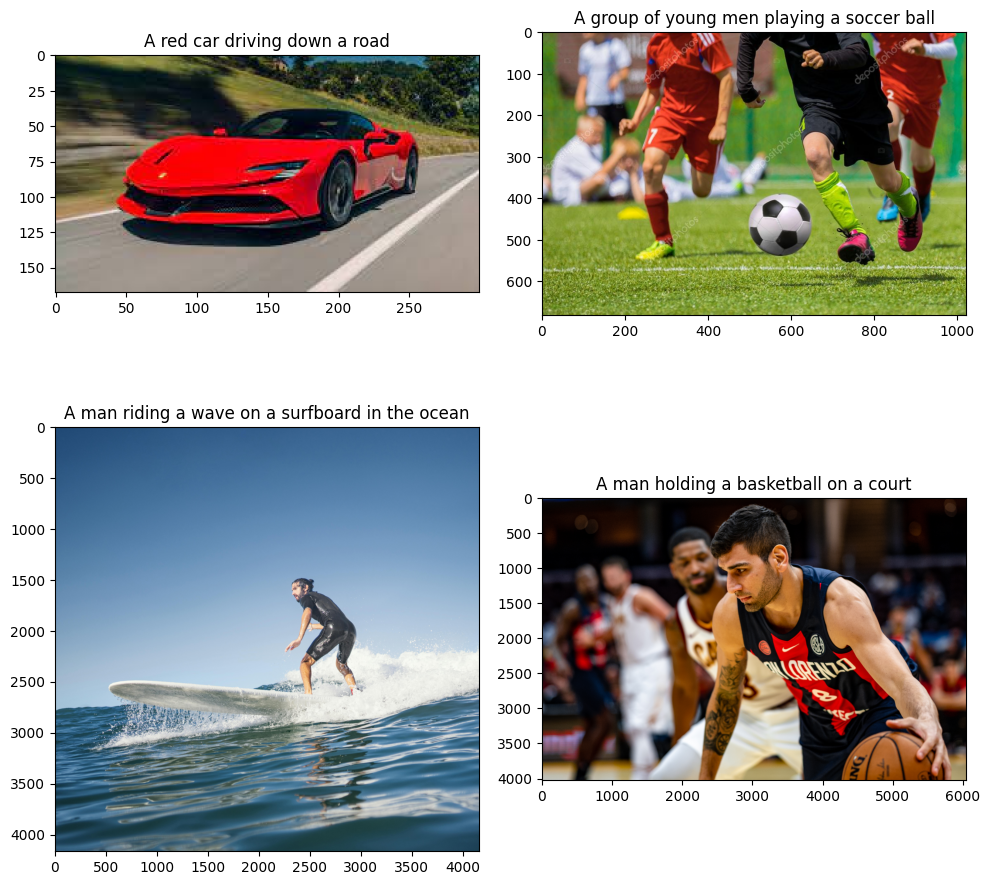

In [48]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    caption, _ = predict_step(test_images[i])
    
    plt.title(caption)
    plt.imshow(cv2.imread(test_images[i])[:, :, (2, 1, 0)])

plt.tight_layout()
plt.savefig('fig.png')